In [1]:
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from keras.utils import plot_model


In [2]:

# Load data
DIR = "D:/Workspace/MIMIC_DATA/mimic-iii-clinical-database-1.4/"
adm_notes = pd.read_csv(DIR + "readmission.csv", low_memory=False)



In [3]:
# Function to clean text
def clean_text(texts):
    texts = texts.str.replace('\n', ' ').str.replace('\r', ' ')
    table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower().translate(table) for text in texts]
    return texts

# Clean the text data
adm_notes = adm_notes.dropna(subset=['TEXT'])
adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

# Ensure no NaN values in text data
adm_notes = adm_notes.dropna(subset=['TEXT'])

In [4]:

# Split data
df_train, df_test = train_test_split(adm_notes, test_size=0.3, random_state=42)
df_train_pos = df_train[df_train['READM_WITHIN_30'] == 1]
df_train_neg = df_train[df_train['READM_WITHIN_30'] == 0]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n=len(df_train_pos), random_state=42)], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
df_test_pos = df_test[df_test['READM_WITHIN_30'] == 1]
df_test_neg = df_test[df_test['READM_WITHIN_30'] == 0]

df_test = pd.concat([df_test_pos, df_test_neg.sample(n=len(df_test_pos), random_state=42)], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=42)



In [5]:
# Tokenize data
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:


pad_token = 0
pad_token_segment_id = 0
max_length = 512

def convert_to_input(texts):
    input_ids, attention_masks, token_type_ids = [], [], []
    for text in tqdm(texts, position=0, leave=True):
        if pd.isna(text):
            continue
        inputs = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_length, return_token_type_ids=True, truncation=True)
        
        i, t = inputs["input_ids"], inputs["token_type_ids"]
        m = [1] * len(i)
        
        padding_length = max_length - len(i)
        
        i = i + ([pad_token] * padding_length)
        m = m + ([0] * padding_length)
        t = t + ([pad_token_segment_id] * padding_length)
        
        input_ids.append(i)
        attention_masks.append(m)
        token_type_ids.append(t)
    
    return [np.asarray(input_ids), np.asarray(attention_masks), np.asarray(token_type_ids)]

X_train_input = convert_to_input(df_train['TEXT'])
X_test_input = convert_to_input(df_test['TEXT'])
X_val_input = convert_to_input(df_val['TEXT'])


100%|██████████| 881/881 [00:31<00:00, 27.84it/s]


In [7]:
# Convert to dataset
def to_features(input_ids, attention_masks, token_type_ids, y):
    return {"input_ids": input_ids, "attention_mask": attention_masks, "token_type_ids": token_type_ids}, y

train_data = (X_train_input[0], X_train_input[1], X_train_input[2], df_train['READM_WITHIN_30'])
test_data = (X_test_input[0], X_test_input[1], X_test_input[2], df_test['READM_WITHIN_30'])
val_data = (X_val_input[0], X_val_input[1], X_val_input[2], df_val['READM_WITHIN_30'])

train_ds = tf.data.Dataset.from_tensor_slices(train_data).map(to_features).shuffle(len(df_train)).batch(10)
test_ds = tf.data.Dataset.from_tensor_slices(test_data).map(to_features).batch(10)
val_ds = tf.data.Dataset.from_tensor_slices(val_data).map(to_features).batch(10)


optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(train_ds, epochs=3, validation_data=val_ds) 


Epoch 1/3
406/406 [==============================] - 16081s 40s/step - loss: 0.6973 - accuracy: 0.5015 - val_loss: 0.6903 - val_accuracy: 0.5482
Epoch 2/3
406/406 [==============================] - 17366s 43s/step - loss: 0.6827 - accuracy: 0.5674 - val_loss: 0.6678 - val_accuracy: 0.6300
Epoch 3/3
406/406 [==============================] - 17129s 42s/step - loss: 0.6565 - accuracy: 0.6160 - val_loss: 0.6864 - val_accuracy: 0.5562


In [9]:
# Evaluate the model
y_pred = model.predict(test_ds, verbose=1)
y_pred_class = np.argmax(y_pred.logits, axis=1)

print(classification_report(df_test['READM_WITHIN_30'], y_pred_class, digits=3))
print(f"ROC-AUC score: {roc_auc_score(df_test['READM_WITHIN_30'], y_pred_class):.3f}")

89/89 [==============================] - 775s 8s/step
              precision    recall  f1-score   support

           0      0.626     0.645     0.635       448
           1      0.621     0.600     0.610       433

    accuracy                          0.623       881
   macro avg      0.623     0.623     0.623       881
weighted avg      0.623     0.623     0.623       881

ROC-AUC score: 0.623


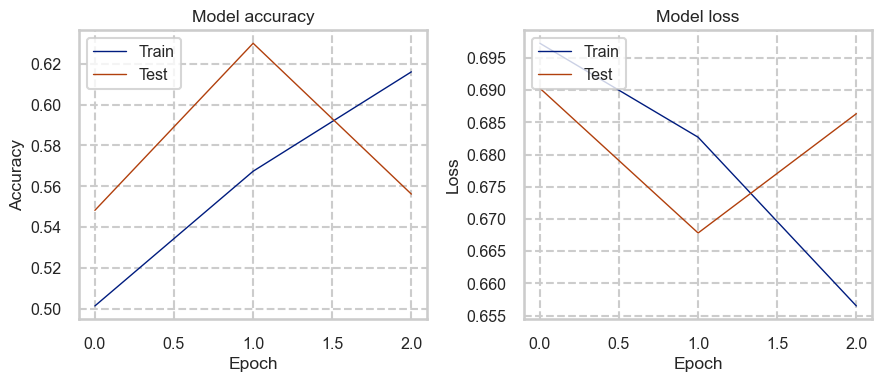

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


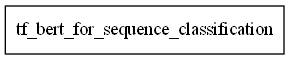

In [11]:

# Plot training history
sns.set('talk', 'whitegrid', 'dark', font_scale=0.7, rc={"lines.linewidth": 1, 'grid.linestyle': '--'})
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')

fig.tight_layout()
plt.show()

model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model)


In [12]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


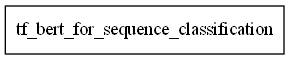

In [13]:

plot_model(model)

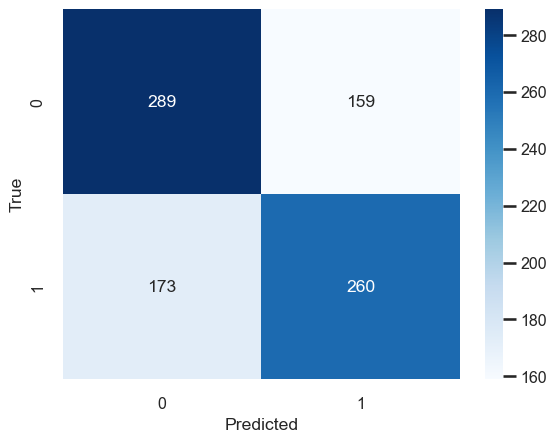

In [14]:


# Plot confusion matrix
cm = confusion_matrix(df_test['READM_WITHIN_30'], y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()